# Introduction

Some initial things about our project and the data

# Import Libraries

In [113]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from transformers import AutoTokenizer
import getpass
import os

In [114]:
# May be needed afterwards.
#!pip install transformers
#!pip install accelerate
#!pip install --upgrade jinja2
#!pip install -U sentence-transformers
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install --upgrade bitsandbytes
#!pip install sentencepiece

# Download the dataset

In [115]:
# Download latest version
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
path = kagglehub.dataset_download("tirendazacademy/fifa-world-cup-2022-tweets")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fifa-world-cup-2022-tweets


In [116]:
# Load the dataset
data = pd.read_csv(path + "/fifa_world_cup_2022_tweets.csv", index_col=0)
print(data.shape)
data.head(10)

(22524, 5)


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative
5,2022-11-20 23:57:32+00:00,0,Twitter for Android,"And like, will the mexican fans be able to scr...",negative
6,2022-11-20 23:57:06+00:00,0,Twitter for Android,Look like a only me and the Jamaican football ...,neutral
7,2022-11-20 23:57:05+00:00,0,Twitter for Android,Really? Football on a Monday morning at 9 and ...,negative
8,2022-11-20 23:56:10+00:00,1,Twitter for iPhone,"As the World Cup starts in Qatar, it’s Black A...",positive
9,2022-11-20 23:56:08+00:00,0,Twitter for iPhone,#WorldCup2022 @ITVSport &amp; @LFSYSTEMMUSIC g...,positive


In [117]:
# To Get the overall info ofcour data (data types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22524 entries, 0 to 22523
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date Created     22524 non-null  object
 1   Number of Likes  22524 non-null  int64 
 2   Source of Tweet  22524 non-null  object
 3   Tweet            22524 non-null  object
 4   Sentiment        22524 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [118]:
data = data[['Tweet','Sentiment']]
data

,Tweet,Sentiment
0,What are we drinking today @TucanTribe \n@MadB...,neutral
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,Worth reading while watching #WorldCup2022 htt...,positive
3,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,"If the BBC cares so much about human rights, h...",negative
...,...,...
22519,Here We go World cup 2022 #WorldCup2022,positive
22520,Anderlecht confirms former Viborg FF's Jesper ...,neutral
22521,Great thread to read before the start of #Worl...,positive
22522,Raphinha wants Brazil to be united at the #Wor...,positive


# Preprocessing

In [119]:
# Drop the duplicates within data to avoid bias and clean data
print(data.shape)
data = data.drop_duplicates()

(22524, 2)


In [120]:
#sanity check
print(data.shape)

(22360, 2)


In [121]:
#check for null values. we dont have any.
data.isnull().sum()

,0
Tweet,0
Sentiment,0


In [122]:
#EDA
countsentiment = data['Sentiment'].value_counts()
print(countsentiment)

Sentiment
positive    8425
neutral     8188
negative    5747
Name: count, dtype: int64


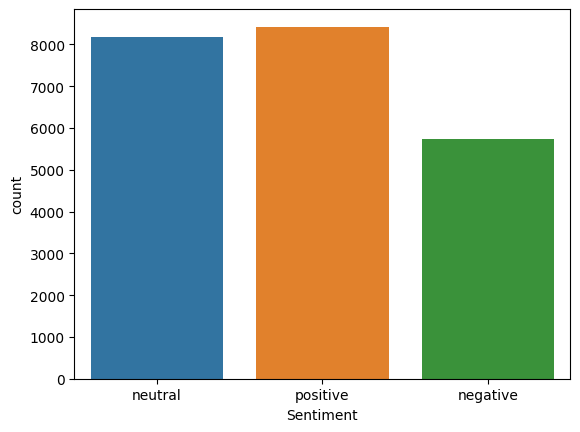

In [123]:
#plot it in a scetterplot
sns.countplot(x='Sentiment', data = data, hue = 'Sentiment');

Some notes:
--we can see that most of the tweets are positive, followed by neutral. This may indicate us the enthusiasm and the positive expectation of the fans. As it seems to have created positive impressions.

In [124]:
#Text preprocessing of the tweets
#lowercase the tweets
def lowercase_text(text):
    return str(text).lower()

In [125]:
# Apply the function to tweets.
# Remember to reassign back to the same column for the changes to take effect.
# Preview your results
data['Tweet'] = data['Tweet'].apply(lowercase_text)
print("After lowercase transformation:")
rand_idxs = np.random.randint(0, len(data['Tweet']), size=10)
for idx in rand_idxs:
    print(f"Sentiment: {data['Sentiment'].iloc[idx]} - Tweet: {data['Tweet'].iloc[idx]}")

After lowercase transformation:
Sentiment: neutral - Tweet: 2022 fifa world cup opening ceremony live stream online

#qatar2022
#fifaworldcup
#openingceremony
#worldcup2022

🔴live tv📺 https://t.co/vv7mwdfhrh

🆚fifa world cup opening ceremony
🆚fifa world cup, qatar 2022
🆚fifa world cup 2022 opening ceremony

sd
Sentiment: positive - Tweet: tomorrow usa plays wales in the world cup! we’ll be opening at 10am and have the game on at 11! 

for all three usa games we’ll be open at 10am for you to watch with us! 11/21, 11/25, and 11/29. go usa! ⚽️🏆
.
.
.
#hellbentbrewing #worldcup #worldcup2022 #drinklocal https://t.co/dhpi06xezv
Sentiment: negative - Tweet: 25 mins into first match i'm already fed up of listening so much whistle from referee 
didn't #qatar or #ecuador trained their players 
so a boring start #worldcup2022
Sentiment: neutral - Tweet: one last time before the games commence.  #israel #worldcup2022 
https://t.co/ipkz7gbjvm
Sentiment: positive - Tweet: oh the memes this is going

/tmp/ipython-input-125-3970920050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lowercase_text)


In [126]:
#stopwords removal
import nltk
nltk.download('stopwords')
base_stopwords = set(stopwords.words('english'))
preserve = {'no', 'not', 'nor', 'never'}
custom_stopwords = base_stopwords - preserve
def remove_stopwords(text):
    words = str(text).split()
    filtered = [word for word in words if word not in custom_stopwords]
    result = ' '.join(filtered)

    if result != text:
        print(f"Before: {text}")
        print(f"After:  {result}\n")

    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
data['Tweet'] = data['Tweet'].apply(remove_stopwords)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
iran has no national team this year in #worldcup2022‌ !

#kianpirfalak 
#mahsaamini 
#iranrevolution https://t.co/4vute8hhkv
After:  fuck football team islamic republic. iran no national team year #worldcup2022‌ ! #kianpirfalak #mahsaamini #iranrevolution https://t.co/4vute8hhkv

Before: i’m behind ghana and uruguay for the world cup. #fifaworldcup #worldcup2022 #qatarworldcup2022 https://t.co/4ye9oconn3
After:  i’m behind ghana uruguay world cup. #fifaworldcup #worldcup2022 #qatarworldcup2022 https://t.co/4ye9oconn3

Before: wouldn't mind if we were 6th.😁

#worldcup2022 ⚽️💪🏻
#poland 🇵🇱🇵🇱🇵🇱❤💪🏻 https://t.co/8ohrcvuhj7 https://t.co/bjxtgujxf1
After:  mind 6th.😁 #worldcup2022 ⚽️💪🏻 #poland 🇵🇱🇵🇱🇵🇱❤💪🏻 https://t.co/8ohrcvuhj7 https://t.co/bjxtgujxf1

Before: so exciting!!! #jungkook will be performing in the #worldcup2022 opening ceremony. the 1st korean artist to headline 💜💜💜💜💜💜💜
#btsarmy #btshistorymakers #bts_twt #fifaworldcup https://

/tmp/ipython-input-127-2244034832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(remove_stopwords)


,Tweet
0,drinking today @tucantribe @madbears_ @lkinc_a...
1,amazing @canadasocceren #worldcup2022 launch v...
2,worth reading watching #worldcup2022 https://t...
3,golden maknae shinning bright https://t.co/4ay...
4,"bbc cares much human rights, homosexual rights..."


In [128]:
#remove URLs, because they didn't add semantic value, and to preserve privacy.
url_pattern = r"(?:https?|ftp)://[^\s/$.?#].[^\s]*"

def replace_urls(text):
    text_str = str(text)
    replaced_text = re.sub(url_pattern, 'URL', text_str)

    if replaced_text != text_str:
        print(f"Before: {text_str}")
        print(f"After:  {replaced_text}\n")

    return replaced_text

In [129]:
data['Tweet'] = data['Tweet'].apply(replace_urls)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After:  fifa 2022 qatar world cup begins today!⚽ cheering #threelions prepare first game iran tomorrow!! 🦁🦁🦁 supporting?👀 #teamengland #fifaworldcup #worldcup2022 #qatar #fifaworldcup2022 #football URL

Before: can’t wait world cup kick today. ⚽ team supporting? share country's flag below. 👇 #cambridgedictionary #worldcup2022 #kickoff https://t.co/euomjzzre9
After:  can’t wait world cup kick today. ⚽ team supporting? share country's flag below. 👇 #cambridgedictionary #worldcup2022 #kickoff URL

Before: gm! enjoy sunday touch grass kickoff #worldcup2022 pulled carrots cold nights arrived! https://t.co/rpgmk5v6dt
After:  gm! enjoy sunday touch grass kickoff #worldcup2022 pulled carrots cold nights arrived! URL

Before: let’s unite support world cup year. support ? think win ? #ambank #worldcup2022 https://t.co/v6lutn9ye8
After:  let’s unite support world cup year. support ? think win ? #ambank #worldcup2022 URL

Before: #fifaworldcup

/tmp/ipython-input-129-204886720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(replace_urls)


,Tweet
0,drinking today @tucantribe @madbears_ @lkinc_a...
1,amazing @canadasocceren #worldcup2022 launch v...
2,worth reading watching #worldcup2022 URL
3,golden maknae shinning bright URL #jeonjungkoo...
4,"bbc cares much human rights, homosexual rights..."


In [130]:

#replace hastags & usernames for the same reasons.
def clean_mentions_hashtags(text):
    original = str(text)
    updated = original

    #Replace full email addresses
    updated = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', updated)

    #Replace users and hashtags
    updated = re.sub(r'@\w+|#\w+', '', updated)

    if updated != original:
        print(f"Before: {original}")
        print(f"After:  {updated}\n")


    return updated

In [131]:
data['Tweet'] = data['Tweet'].apply(clean_mentions_hashtags)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After:  wash sport public? deflect cost corrupt regime winner sport one that’s lost      URL

Before: ⚽️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL #wc2022 #worldcup2022 #qatar2022 URL
After:  ⚽️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL    URL

Before: spot palestinian flag ?✨🇵🇸 hours away 🇶🇦 #qatarworldcup2022 #worldcup2022 URL
After:  spot palestinian flag ?✨🇵🇸 hours away 🇶🇦   URL

Before: spirit #worldcup2022. watching world cup match, make sure also play match well. 🤪#gbagagbabitters 🌿 dey you. #backtotheroots #gbagagba. URL
After:  spirit . watching world cup match, make sure also play match well. 🤪 🌿 dey you.  . URL

Before: guess player world cup wins history? 🏆⚽️ #fifaworldcup #qatar2022 #worldcup #f

/tmp/ipython-input-131-219291766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(clean_mentions_hashtags)


,Tweet
0,drinking today URL
1,amazing launch video. shows much face canada...
2,worth reading watching URL
3,golden maknae shinning bright URL
4,"bbc cares much human rights, homosexual rights..."


In [132]:
#remove emojis without emoticons because they add sentiment
emoji_pattern = re.compile("["

    # Symbols & pictographs (e.g., 🔥🎉💡📦📱)
    u"\U0001F300-\U0001F5FF"

    # Transport & map symbols (e.g., 🚗✈️🚀🚉)
    u"\U0001F680-\U0001F6FF"

    # Flags (e.g., 🇺🇸🇬🇧🇨🇦 — these are pairs of regional indicators)
    u"\U0001F1E0-\U0001F1FF"

    # Dingbats (e.g., ✂️✈️✉️⚽)
    u"\u2700-\u27BF"

    # Supplemental Symbols & Pictographs (e.g., 🤖🥰🧠🦾)
    u"\U0001F900-\U0001F9FF"

    # Symbols & Pictographs Extended-A (e.g., 🪄🪅🪨)
    u"\U0001FA70-\U0001FAFF"

    # Miscellaneous symbols (e.g., ☀️☁️☂️⚡)
    u"\u2600-\u26FF"

    "]+", flags=re.UNICODE)

In [133]:
def remove_emojis(text):
    if emoji_pattern.search(text):
        print(f"Before: {text}")
        text = emoji_pattern.sub('', text)
        print(f"After: {text}")
        print()
    return text

In [134]:
data['Tweet'] = data['Tweet'].apply(remove_emojis)
data['Tweet'].head()

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After: watch enjoy favorite games us nasinya grill &amp; restaurant          call whatsapp visit today 😊 0705889121    URL

Before:  let football talk 💪🏻&gt;&gt; no hypocrisy  ❤️
After:  let football talk &gt;&gt; no hypocrisy  ️

Before: so, result qatar ecuador world cup opener? 🔥🤔             
After: so, result qatar ecuador world cup opener?              

Before: ⚽️the fifa world cup 2022 kicks today!⚽️ 🏴󠁧󠁢󠁥󠁮󠁧󠁿bring home england! 🏴󠁧󠁢󠁥󠁮󠁧󠁿       URL
After: ️the fifa world cup 2022 kicks today!️ 󠁧󠁢󠁥󠁮󠁧󠁿bring home england! 󠁧󠁢󠁥󠁮󠁧󠁿       URL

Before: predictions formation starting lineup qatar go ecuador!👇 ~         URL
After: predictions formation starting lineup qatar go ecuador! ~         URL

Before: 🚨 world cup £50 giveaway! 🚨 bet builder opening game wins, give away winning amount one follower retweets tweet! 💷💷💷💷💷💷💷💷💷💷💷💷  🏆  URL
After:  world cup £50 giveaway!  bet builder opening game wins, give away winning amount one follow

/tmp/ipython-input-134-3524784530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(remove_emojis)


,Tweet
0,drinking today URL
1,amazing launch video. shows much face canada...
2,worth reading watching URL
3,golden maknae shinning bright URL
4,"bbc cares much human rights, homosexual rights..."


In [135]:
#remove non-alphabets
def clean_text(text, keep_punct=False):
    original = str(text)

    if keep_punct:
        # Keep only lowercase letters, spaces, and select punctuation (. ! ?), for capturing tone/sentiment
        cleaned = re.sub(r"[^a-z\s.!?]", "", original)
    else:
        # Keep only lowercase letters and spaces; remove all punctuation and symbols
        cleaned = re.sub(r"[^a-z\s]", "", original)

    # Normalize whitespace
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    if original != cleaned:
        print(f"Before: {text}")
        print(f"After:  {cleaned}\n")

    return cleaned

In [136]:
data['Tweet'] = data['Tweet'].apply(lambda x: clean_text(x, keep_punct=True))

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
After:  would love english football brass band medleys gay anthems icons. surely fans see great humour too. could anyone stop that?

Before: wash sport public? deflect cost corrupt regime winner sport one that’s lost      URL
After:  wash sport public? deflect cost corrupt regime winner sport one thats lost

Before: ️ finally! 22nd fifa world cup kicks today. qatar play ecuador opening match. history world cup, hosts never started tournament defeat – 16 wins 6 draws: URL    URL
After:  finally! nd fifa world cup kicks today. qatar play ecuador opening match. history world cup hosts never started tournament defeat wins draws

Before: spot palestinian flag ? hours away    URL
After:  spot palestinian flag ? hours away

Before: spirit . watching world cup match, make sure also play match well.   dey you.  . URL
After:  spirit . watching world cup match make sure also play match well. dey you. .

Before: guess player world cup wins his

/tmp/ipython-input-136-2274118247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lambda x: clean_text(x, keep_punct=True))


In [137]:
def remove_consecutive_letters(text, max_repeat=2):
    text_str = str(text)
    pattern = r'(\w)\1{' + str(max_repeat) + r',}'
    cleaned = re.sub(pattern, r'\1' * max_repeat, text_str)

    if cleaned != text_str:
        print(f"Before: {text_str}")
        print(f"After:  {cleaned}\n")

    return cleaned

In [138]:
data['Tweet'] = data['Tweet'].apply(lambda x: remove_consecutive_letters(x, max_repeat=2))

Before: day lets watch fooootttttbaaaaallllllll!
After:  day lets watch foottbaall!

Before: reviewing video even header pass player forward direction. went straight even looks like deflected goalie. offside? pffft...more like .
After:  reviewing video even header pass player forward direction. went straight even looks like deflected goalie. offside? pfft...more like .

Before: lets gooooooooo team usa!!!
After:  lets goo team usa!!!

Before: less hours go s first match.lets go boysssss!!!
After:  less hours go s first match.lets go boyss!!!

Before: lmaoooo saudi dey memorise quran blow everything .btstwt .btsbighit
After:  lmaoo saudi dey memorise quran blow everything .btstwt .btsbighit

Before: worldcupcryptomeme kkkkkkkkk
After:  worldcupcryptomeme kk

Before: lets fucking gollllllllll
After:  lets fucking goll

Before: lets go argentinaaaa lets hope best. goat deserves it.
After:  lets go argentinaa lets hope best. goat deserves it.

Before: watched prediction video thought show 

/tmp/ipython-input-138-3337271836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lambda x: remove_consecutive_letters(x, max_repeat=2))


In [139]:
#Lemmatization
# Download required NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [140]:
# POS mapping function
# POS tags can be: ADJ (adjective), ADV (adverb), NOUN (noun), VERB (verb), etc
def get_wordnet_pos(tag):
    # Determine the WordNet POS tag based on the first letter of the input tag
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun if no match


def lemmatize_text(text):
    original_text = str(text)
    # Split the text into individual words
    words = original_text.split()
    # Obtain Part of Speech (POS) tags for each word
    pos_tags = pos_tag(words)

    # Initialize lists to store lemmatized words and any changes
    lemmatized_words = []
    changes = []

    # Iterate over each word and its POS tag
    for word, tag in pos_tags:
        # Map the POS tag to a WordNet POS tag
        wn_tag = get_wordnet_pos(tag)
        # Lemmatize the word using the mapped POS tag
        lemma = lemmatizer.lemmatize(word, wn_tag)

        # Check if the lemmatized word is different from the original
        if lemma != word:
            # Record the change if a difference is found
            changes.append((word, lemma, tag))
        # Add the lemmatized word to the list
        lemmatized_words.append(lemma)

    # Join the lemmatized words back into a single string
    result = ' '.join(lemmatized_words)

    if changes:
        print(f"\nOriginal: {original_text}")
        print(f"Lemmatized: {result}")
        for original, lemma, pos in changes:
            print(f"  - {original} → {lemma}  (POS: {pos})")

    return result

In [141]:
nltk.download('averaged_perceptron_tagger_eng')
data['Tweet'] = data['Tweet'].apply(lemmatize_text)
data['Tweet']


Original: amazing launch video. shows much face canada mens national team changed since last world cup entry . cant wait see boys action! canada fifa world cup opening video
Lemmatized: amaze launch video. show much face canada mens national team change since last world cup entry . cant wait see boy action! canada fifa world cup open video
  - amazing → amaze  (POS: VBG)
  - shows → show  (POS: VBZ)
  - changed → change  (POS: VBD)
  - boys → boy  (POS: NNS)
  - opening → open  (POS: VBG)

Original: worth reading watching
Lemmatized: worth read watch
  - reading → read  (POS: VBG)
  - watching → watch  (POS: VBG)

Original: golden maknae shinning bright
Lemmatized: golden maknae shin bright
  - shinning → shin  (POS: VBG)

Original: bbc cares much human rights homosexual rights women rights not say opening ceremony?? saying opening ceremony?? bbc censor opening ceremony??
Lemmatized: bbc care much human right homosexual right woman right not say open ceremony?? say open ceremony?? bbc

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  - biggest → big  (POS: JJS)
  - lets → let  (POS: VBZ)

Original: carry quatar airline ads given news coverage rightly exposes oppression exploitation society?
Lemmatized: carry quatar airline ad give news coverage rightly expose oppression exploitation society?
  - ads → ad  (POS: NNS)
  - given → give  (POS: VBN)
  - exposes → expose  (POS: VBZ)

Original: song crazy! captures emotion well. amount people not listening song made makes sad
Lemmatized: song crazy! capture emotion well. amount people not listen song make make sad
  - captures → capture  (POS: VBZ)
  - listening → listen  (POS: VBG)
  - made → make  (POS: VBD)
  - makes → make  (POS: VBZ)

Original: years ago! remember britney fifa world cup commercial pepsi
Lemmatized: year ago! remember britney fifa world cup commercial pepsi
  - years → year  (POS: NNS)

Original: check captaincy works best options md!
Lemmatized: check captaincy work best option md!
  - works → 

/tmp/ipython-input-141-2567611865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lemmatize_text)


,Tweet
0,drinking today
1,amaze launch video. show much face canada mens...
2,worth read watch
3,golden maknae shin bright
4,bbc care much human right homosexual right wom...
...,...
22519,go world cup
22520,anderlecht confirm former viborg ffs jesper fr...
22521,great thread read start
22522,raphinha want brazil united


In [142]:
data.head(5)

,Tweet,Sentiment
0,drinking today,neutral
1,amaze launch video. show much face canada mens...,positive
2,worth read watch,positive
3,golden maknae shin bright,positive
4,bbc care much human right homosexual right wom...,negative


In [143]:
Tweet = data["Tweet"]
Sentiment = data["Sentiment"]

In [144]:
Sentiment.head(5)

,Sentiment
0,neutral
1,positive
2,positive
3,positive
4,negative


In [145]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Sentiment = le.fit_transform(Sentiment)       ##.reshape(-1,1)
Sentiment = Sentiment + 1

In [146]:
import torch
import random
import numpy as np
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)

In [147]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from datetime import datetime

# Example preprocessing: tokenize and build vocab

In [148]:
from collections import Counter
import torch
from torch.utils.data import Dataset


class TextDataset(Dataset):
    """A minimal Dataset for turning raw sentences into fixed-length
    sequences of token IDs that can be fed to a neural network.

    Parameters
    ----------
    texts : List[str]
        Sentences/documents to be classified.
    labels : List[int]
        Integer class labels (e.g. 1-5 star ratings).
    vocab : Dict[str, int], optional
        Pre-built mapping from token → integer index. If *None*, one will
        be built from *texts*.
    max_len : int, default=20
        Sentences longer than *max_len* are truncated; shorter ones are
        padded with the <PAD> token so every sample has identical length.
    """

    def __init__(self, texts, labels, vocab=None, max_len: int = 20):
        self.max_len = max_len

        # Tokenise each sentence by simple whitespace splitting and make
        # everything lowercase so that "Dog" and "dog" map to the same token.
        self.texts = [t.lower().split() for t in texts]
        self.labels = labels

        if vocab is None:
            # Build a frequency counter for all words appearing in the
            # training corpus so we can assign them stable indices.
            counter = Counter(word for text in self.texts for word in text)

            # Reserve *two* indices for special tokens that don't correspond
            # to real words. We start ordinary words at index 2 so that 0 and
            # 1 are free for these special cases:
            #   <PAD> (index 0) — Padding token used purely to make all
            #                     sequences the same length within a batch.
            #                     It carries *no* semantic meaning. Models
            #                     learn to ignore it via masking or by having
            #                     an embedding vector that is not updated.
            #   <UNK> (index 1) — «UNKnown» token assigned to any word that
            #                     was *not* present in the vocabulary at the
            #                     time of building/training. Collapsing every
            #                     unseen word to a single ID keeps the
            #                     vocabulary compact and protects the model
            #                     from crashing when it encounters an
            #                     out-of-vocabulary term at test time.
            # The self.vocab is a dictionary that maps each word to its corresponding index in the vocabulary.
            # The vocabulary is built from the most common words in the training corpus. If input n of most_common is None, then list all element counts.
            # The most_common method returns a list of tuples, where each tuple contains a word and its count in the corpus.
            # The enumerate function is used to pair each word with its index in the vocabulary.
            # The +2 is used to reserve the first two indices for the special tokens <PAD> and <UNK>.
            self.vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common())}
            self.vocab['<PAD>'] = 0
            # The <PAD> and <UNK> tokens are assigned indices 0 and 1 respectively.
            self.vocab['<UNK>'] = 1
        else:
            # If the vocabulary is already built, then use the pre-built vocabulary.
            self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def encode_text(self, text):
        """Convert a tokenised *text* (list of str) into a tensor of IDs, which is a tensor of shape (max_len,) and is useful for feeding into the pytorch model.

        Any word that is not in *self.vocab* maps to the <UNK> index so that
        the network receives *some* vector rather than crashing. If the
        resulting sequence is shorter than *max_len* we append <PAD> IDs
        until it reaches the desired length; if it is longer we truncate the
        tail. The output is therefore always of shape (max_len,).
        """

        # Map every word to its ID, defaulting to <UNK> (1) when necessary.
        ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]

        # Pad or truncate to fixed length so that we can stack multiple
        # samples into a single tensor of shape (batch_size, max_len).
        if len(ids) < self.max_len:
            # Add as many <PAD> (0) tokens as needed.
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        else:
            ids = ids[: self.max_len]

        return torch.tensor(ids)

    def __getitem__(self, idx):
        # Fetch the already-tokenised sentence and convert it to IDs.
        text_tensor = self.encode_text(self.texts[idx])

        # Adjust label range from 1-5 → 0-4 because PyTorch's
        # CrossEntropyLoss expects class IDs starting at 0.
        label_tensor = torch.tensor(self.labels[idx] - 1)

        return text_tensor, label_tensor

Model

In [149]:
# This is the class for the deep learning model. nn.Module is the parent class for all neural network modules in PyTorch.
class DLModel(nn.Module):
    def __init__(
        self, # This is the self parameter, which is the instance of the class
        vocab_size, # This is the size of the vocabulary
        embed_dim, # This is the dimension of the embedding layer
        hidden_dim, # This is the dimension of the hidden layer
        output_dim, # This is the dimension of the output layer
        model_type='RNN', # This is the type of the model
        num_layers=1, # This is the number of layers in the model
        dropout_prob=0.5 # This is the dropout probability
    ):
        super().__init__() # This is the super() function, which is the parent class of the class
        # Initialize the embedding layer with the given vocabulary size and embedding dimension
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Initialize the recurrent layer based on the specified model type
        if model_type == 'RNN':
            # Use RNN with specified parameters
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'LSTM':
            # Use LSTM with specified parameters
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                               dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'GRU':
            # Use GRU with specified parameters
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        else:
            # Raise an error if an unsupported model type is provided
            raise ValueError('model_type must be RNN, LSTM, or GRU')

        # Initialize batch normalization for the hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        # Initialize dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)
        # Initialize the fully connected layer for output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embed the input sequence
        embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embed_dim]
        # Pass the embedded sequence through the recurrent layer
        output, hidden = self.rnn(embedded)

        # Check if the hidden state is a tuple (for LSTM)
        if isinstance(hidden, tuple):  # For LSTM
            hidden = hidden[0]  # Use the hidden state, not the cell state

        # Use the last layer's hidden state
        hidden = hidden[-1]  # Shape: [batch_size, hidden_dim]
        # Apply batch normalization
        hidden = self.batch_norm(hidden)  # BatchNorm expects shape [batch_size, features]
        # Apply dropout for regularization
        hidden = self.dropout(hidden)
        # Pass through the fully connected layer to get the output
        out = self.fc(hidden)
        return out  # Return the final output

Prepare Data

In [150]:
# Convert the 'Tweet' column of the DataFrame to a list of texts
texts = Tweet.tolist()
# Display the first 5 elements of the list for inspection
texts[:5]

['drinking today',
 'amaze launch video. show much face canada mens national team change since last world cup entry . cant wait see boy action! canada fifa world cup open video',
 'worth read watch',
 'golden maknae shin bright',
 'bbc care much human right homosexual right woman right not say open ceremony?? say open ceremony?? bbc censor open ceremony??']

In [151]:
# Convert the 'Sentiment' column of the DataFrame to a list of integer labels
labels = Sentiment.astype(int).tolist()
# Display the first 5 elements of the labels list for inspection
labels[:5]

[2, 3, 3, 3, 1]

In [152]:
# Split the data into training and testing sets
# 'train_test_split' is used to randomly partition the data
# 'texts' and 'labels' are split into training and testing subsets
# 'test_size=0.2' indicates 20% of the data will be used for testing
# 'random_state=42' ensures reproducibility of the split
# 'stratify=labels' ensures the class distribution is preserved in both sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [153]:
# We will not use the full max_len.
# Let’s say our longest review title is 120 words, but 95% are under 25.
# Using max_len=120 wastes computation and memory on padding for most inputs.
# Long sequences may slow down training and cause overfitting.
# It makes batches less dense (more padding = less useful gradient info).
# Hence we will use the 95th percentile of the lengths. This gives you a smart cap on sequence length, keeping training efficient without losing too much signal from long examples.
lengths = [len(t.lower().split()) for t in train_texts]
max_len = int(np.percentile(lengths, 95))  # or max(lengths) if you want the absolute max
max_len

22

In [154]:
train_dataset = TextDataset(train_texts, train_labels, max_len=max_len)
test_dataset = TextDataset(test_texts, test_labels, vocab=train_dataset.vocab, max_len=max_len)

In [155]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Hyperparameters

In [156]:
# Determine the size of the vocabulary from the training dataset
vocab_size = len(train_dataset.vocab)
# Set the embedding dimension for the model
embed_dim = 384
# Set the hidden layer dimension for the model
hidden_dim = 256
# Define the output dimension, corresponding to the number of classes (1-5 stars)
output_dim = 3  # 5 classes (1-5 stars)
# Specify the type of model to use; options include 'RNN', 'LSTM', or 'GRU'
model_type = 'RNN'  # <-- CHANGE HERE to 'RNN' or 'LSTM' or 'GRU'
# Set the number of layers in the model
number_of_layers = 1

# Model, loss, optimizer

In [157]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Display the device being used (either 'cuda' for GPU or 'cpu' for CPU)
device

device(type='cpu')

In [158]:
# Initialize the deep learning model with the specified parameters:
# - vocab_size: size of the vocabulary from the training dataset
# - embed_dim: dimension of the embedding layer
# - hidden_dim: dimension of the hidden layer
# - output_dim: number of output classes (1-5 stars)
# - model_type: type of model to use ('RNN', 'LSTM', or 'GRU')
# - num_layers: number of layers in the model
# Move the model to the specified device (GPU if available, otherwise CPU)
model = DLModel(vocab_size, embed_dim, hidden_dim, output_dim, model_type, num_layers=number_of_layers).to(device)

In [159]:
# The criterion is the loss function used to evaluate the performance of the model during training.
# It measures the difference between the predicted outputs and the actual target values.
# In this context, we are using CrossEntropyLoss, which is suitable for multi-class classification problems.
# This loss function computes the cross-entropy loss between the predicted class probabilities and the true class labels.
# It is particularly effective for tasks where the model outputs a probability distribution over multiple classes.
criterion = nn.CrossEntropyLoss()

In [160]:
# Initialize the optimizer for the model's parameters using the Adam optimization algorithm.
# Adam is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks.
# It combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.
# This optimizer will adjust the learning rate for each parameter dynamically, which can lead to faster convergence.
optimizer = optim.Adam(model.parameters())

In [161]:
# Set the number of epochs for training the model
# An epoch is one complete forward and backward pass of all the training examples
# More epochs can lead to better training but may also cause overfitting
nof_epochs = 5

In [162]:
def evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss):
    # Initialize variables to track test loss and correct predictions
    test_loss = 0
    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0

    # Calculate train accuracy
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_train += (preds == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples
    train_accuracy = correct_train / total_train  # Calculate train accuracy
    train_accuracies.append(train_accuracy)  # Append train accuracy to the list

    # Calculate test loss and accuracy
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item()  # Accumulate test loss
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_test += (preds == targets).sum().item()  # Count correct predictions
            total_test += targets.size(0)  # Count total samples
    test_loss /= len(test_loader)  # Average test loss over all batches
    test_losses.append(test_loss)  # Append test loss to the list
    test_accuracy = correct_test / total_test  # Calculate test accuracy
    test_accuracies.append(test_accuracy)  # Append test accuracy to the list

    print(100*"=")  # Print separator for readability
    # Print current epoch, train loss, test loss, train accuracy, and test accuracy
    print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(100*"=")  # Print separator for readability

In [163]:
# Import the time module to work with time-related functions
import time
# Record the current time to measure the elapsed time during training
start_time = time.time()

In [164]:
# Initialize lists to store training and testing accuracies for each epoch
train_accuracies = []
test_accuracies = []

# Initialize lists to store training and testing losses for each epoch
train_losses = []
test_losses = []

# Initial Accuracy

In [165]:
train_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item() for inputs, targets in train_loader) / len(train_loader)
train_losses.append(train_loss)
train_loss

1.251169092314584

In [166]:
evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, -1, train_loss)

2025-07-17 16:07:47, Epoch 0, Train Loss: 1.2512, Test Loss: 1.1791, Train Accuracy: 0.2625, Test Accuracy: 0.2616


In [167]:
print(pd.DataFrame(Sentiment).value_counts())

0
3    8425
2    8188
1    5747
Name: count, dtype: int64


Training Loop

In [168]:
# Loop over each epoch
for epoch in range(nof_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss for the current epoch
    # Loop over each batch in the training data
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

        optimizer.zero_grad()  # Reset gradients for the optimizer
        outputs = model(inputs)  # Forward pass: compute model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate training loss

        # Print progress every 10% of the training data
        if idx % (len(train_loader) // 10) == 0:
           print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Batch {idx+1}/{len(train_loader)}, Train Loss: {train_loss/(idx+1):.4f}, Elapsed: {(time.time() - start_time)/60:.5f} min")
    train_loss = train_loss / len(train_loader)  # Average training loss over all batches
    train_losses.append(train_loss)  # Append training loss to the list

    # Evaluate the model on training and test data
    evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss)

2025-07-17 16:07:48, Epoch 1, Batch 1/35, Train Loss: 1.2572, Elapsed: 0.14347 min
2025-07-17 16:07:49, Epoch 1, Batch 4/35, Train Loss: 1.2375, Elapsed: 0.16237 min
2025-07-17 16:07:50, Epoch 1, Batch 7/35, Train Loss: 1.2194, Elapsed: 0.18712 min
2025-07-17 16:07:52, Epoch 1, Batch 10/35, Train Loss: 1.2055, Elapsed: 0.21388 min
2025-07-17 16:07:53, Epoch 1, Batch 13/35, Train Loss: 1.1962, Elapsed: 0.23531 min
2025-07-17 16:07:54, Epoch 1, Batch 16/35, Train Loss: 1.1872, Elapsed: 0.25446 min
2025-07-17 16:07:55, Epoch 1, Batch 19/35, Train Loss: 1.1849, Elapsed: 0.27328 min
2025-07-17 16:07:56, Epoch 1, Batch 22/35, Train Loss: 1.1816, Elapsed: 0.28959 min
2025-07-17 16:07:57, Epoch 1, Batch 25/35, Train Loss: 1.1776, Elapsed: 0.30773 min
2025-07-17 16:07:58, Epoch 1, Batch 28/35, Train Loss: 1.1786, Elapsed: 0.32540 min
2025-07-17 16:08:00, Epoch 1, Batch 31/35, Train Loss: 1.1746, Elapsed: 0.34361 min
2025-07-17 16:08:01, Epoch 1, Batch 34/35, Train Loss: 1.1731, Elapsed: 0.36170

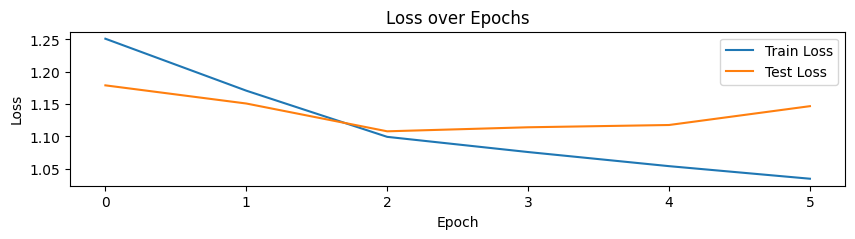

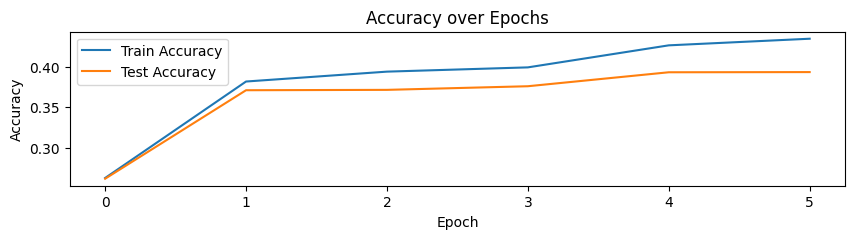

In [169]:
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting

# Plot training and test loss
plt.figure(figsize=(10, 2))  # Create a new figure with a specified size
plt.plot(train_losses, label='Train Loss')  # Plot the training loss with a label
plt.plot(test_losses, label='Test Loss')  # Plot the test loss with a label
plt.title('Loss over Epochs')  # Set the title of the plot
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend()  # Display the legend to differentiate between plots
plt.show()  # Show the plot

# Plot training and test accuracy
plt.figure(figsize=(10, 2))  # Create another figure for accuracy plots
plt.plot(train_accuracies, label='Train Accuracy')  # Plot the training accuracy with a label
plt.plot(test_accuracies, label='Test Accuracy')  # Plot the test accuracy with a label
plt.title('Accuracy over Epochs')  # Set the title of the accuracy plot
plt.xlabel('Epoch')  # Set the x-axis label for accuracy
plt.ylabel('Accuracy')  # Set the y-axis label for accuracy
plt.legend()  # Display the legend for accuracy plots
plt.show()  # Show the accuracy plot

Test Accuracy

In [170]:
from sklearn.metrics import classification_report  # Import classification_report from sklearn.metrics for evaluation

# Test + collect predictions
model.eval()  # Set the model to evaluation mode
all_preds = []  # Initialize a list to store all predictions
all_targets = []  # Initialize a list to store all true targets

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:  # Iterate over the test data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
        outputs = model(inputs)  # Get model outputs
        preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

# Print classification report
print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report

              precision    recall  f1-score   support

           0     0.3465    0.0386    0.0694      1141
           1     0.5636    0.0802    0.1404      1659
           2     0.3848    0.9456    0.5470      1672

    accuracy                         0.3931      4472
   macro avg     0.4316    0.3548    0.2522      4472
weighted avg     0.4413    0.3931    0.2743      4472



In [171]:
from sklearn.metrics import classification_report  # Import classification_report for evaluating model performance

# Train + collect predictions
model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization

all_preds = []  # Initialize a list to store predictions from the model
all_targets = []  # Initialize a list to store true target values

with torch.no_grad():  # Disable gradient calculation for efficiency during evaluation
    for inputs, targets in train_loader:  # Iterate over the training data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device (CPU or GPU)
        outputs = model(inputs)  # Get model outputs for the inputs
        preds = outputs.argmax(dim=1)  # Determine predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

# Print classification report
print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report with 4 decimal places

              precision    recall  f1-score   support

           0     0.8324    0.0981    0.1756      4606
           1     0.8171    0.1054    0.1867      6529
           2     0.4016    0.9815    0.5700      6753

    accuracy                         0.4343     17888
   macro avg     0.6837    0.3950    0.3107     17888
weighted avg     0.6642    0.4343    0.3285     17888

